In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from netCDF4 import Dataset

import seaborn as sns



import matplotlib.pyplot as plt

path = os.getcwd()

import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.__version__)
print(device_lib.list_local_devices())

import xgboost as xgb
import pickle

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18071052433982236662
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3645898752
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11846815104752956037
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


## 예측모델

### 데이터셋 구축

In [2]:
# In[] SMOKE-CMAQ
# CMAQ 연평균 PM농도
pm2_5 = np.array([])

for i in range(1,120):
    a = 'ACONC.' + str(i)
    nc = Dataset(a, 'r')
    pm2_5 = np.append(pm2_5, np.array([[[nc.variables['PM2_5']]]]))
    
pm2_5 = np.reshape(pm2_5, [119,82,67])
pm2_5 = pm2_5[:,8:-10,2:-1]
pm2_5 = np.reshape(pm2_5, [119,64,64]) # convolution 연산을 위해

pm = pm2_5


y1 = np.array([])
y2 = np.array([])
y3 = np.array([])
y4 = np.array([])
y5 = np.array([])
y6 = np.array([])

for i in range(1,120):
    a = 'EMIS_AVG.' + str(i)
    nc = Dataset(a, 'r')
    y1 = np.append(y1, np.array([[[nc.variables['SO2']]]]))
    y2 = np.append(y2, np.array([[[nc.variables['PM2_5']]]]))
    y3 = np.append(y3, np.array([[[nc.variables['NOx']]]]))
    y4 = np.append(y4, np.array([[[nc.variables['VOCs']]]]))
    y5 = np.append(y5, np.array([[[nc.variables['NH3']]]]))
    y6 = np.append(y6, np.array([[[nc.variables['CO']]]]))
    
y1 = np.reshape(y1, [119,82,67])
y1 = y1[:,8:-10,2:-1]
y1 = np.reshape(y1, [119,64,64])
y1_max = np.max(y1)
y1_min = np.min(y1)

y2 = np.reshape(y2, [119,82,67])
y2 = y2[:,8:-10,2:-1]
y2 = np.reshape(y2, [119,64,64])
y2_max = np.max(y2)
y2_min = np.min(y2)

y3 = np.reshape(y3, [119,82,67])
y3 = y3[:,8:-10,2:-1]
y3 = np.reshape(y3, [119,64,64])
y3_max = np.max(y3)
y3_min = np.min(y3)

y4 = np.reshape(y4, [119,82,67])
y4 = y4[:,8:-10,2:-1]
y4 = np.reshape(y4, [119,64,64])
y4_max = np.max(y4)
y4_min = np.min(y4)

y5 = np.reshape(y5, [119,82,67])
y5 = y5[:,8:-10,2:-1]
y5 = np.reshape(y5, [119,64,64])
y5_max = np.max(y5)
y5_min = np.min(y5)
    
y6 = np.reshape(y6, [119,82,67])
y6 = y6[:,8:-10,2:-1]
y6 = np.reshape(y6, [119,64,64])


def pm_data():
    a = np.concatenate((y3,y1,y4,y5), axis=0) # PM2.5, SO2, NH3
    a = np.reshape(a,[4,119,64,64]) # data generation for CNN ??
    a = np.transpose(a, (1,2,3,0)) # CNN 학습을 위한 순서변경
    print(np.shape(a))
    
    y = pm
    
    y = np.reshape(y, [119,64,64,1]) # CNN output data
    x_train = a[0:70]
    y_train = y[0:70]
    x_test = a[70:]
    pm2_5 = y[70:]
    return x_train, y_train, x_test, pm2_5, a, y


pm_data1 = pm_data()
x_train, y_train, x_test, pm2_5, a, y = pm_data1[0], pm_data1[1], pm_data1[2], pm_data1[3], pm_data1[4], pm_data1[5]#, pm_data1[6], pm_data1[7] 


(119, 64, 64, 4)


In [3]:
x_train.shape

(70, 64, 64, 4)

### 예측네트워크 구축

In [4]:
class CBR2d(tf.keras.layers.Layer):
    def __init__(self, out_channels,kernel_size = 3):
        super(CBR2d, self).__init__()
        self.cnn_layer = tf.keras.layers.Conv2D(out_channels, kernel_size, activation='relu', padding='same')
        self.batch_layer = tf.keras.layers.BatchNormalization()
              
    def call(self, inputs):
        cnn_feat_x = self.cnn_layer(inputs)
        batched_feat = self.batch_layer(cnn_feat_x)
        return batched_feat

class Unet(tf.keras.Model): 
    def __init__(self,): 
        super(Unet, self).__init__()

        self.enc1_1 = CBR2d(out_channels = 64) 
        self.enc1_2 = CBR2d(out_channels=64)
            
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        self.enc2_1 = CBR2d(out_channels=128)
        self.enc2_2 = CBR2d(out_channels=128)
        
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        self.enc3_1 = CBR2d(out_channels=256)
        self.enc3_2 = CBR2d(out_channels=256)
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )

        self.enc4_1 = CBR2d(out_channels=512)
        self.enc4_2 = CBR2d(out_channels=512)
        self.pool4 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        
        self.enc5_1 = CBR2d(out_channels=1024)
        self.dec5_1 = CBR2d(out_channels=512)

        self.unpool4 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=2,strides=(2, 2))

        self.dec4_2 = CBR2d(out_channels=512)
        self.dec4_1 = CBR2d(out_channels=256)

        self.unpool3 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=2,strides=(2, 2))

        self.dec3_2 = CBR2d(out_channels=256)
        self.dec3_1 = CBR2d(out_channels=128)

        self.unpool2 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=2,strides=(2, 2))

        self.dec2_2 = CBR2d(out_channels=128)
        self.dec2_1 = CBR2d(out_channels=64)

        self.unpool1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=2,strides=(2, 2))

        self.dec1_2 = CBR2d(out_channels=64)
        self.dec1_1 = CBR2d(out_channels=64)

        self.outlayer = tf.keras.layers.Conv2D(1,kernel_size = 1)
              
    def call(self, input): 
      
        enc1_1 = self.enc1_1(input)
        enc1_2 = self.enc1_2(enc1_1)
        
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        
        pool2= self.pool2(enc2_2)
  
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        
        pool3= self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        
        pool4= self.pool3(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        
        dec5_1 = self.dec5_1(enc5_1)
        

        unpool4 = self.unpool4(dec5_1)

        cat4 = tf.keras.layers.Concatenate(axis=3)([unpool4, enc4_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)
       
        unpool3 = self.unpool3(dec4_1)
    
        cat3 = tf.keras.layers.Concatenate(axis=3)([unpool3, enc3_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        
        unpool2 = self.unpool2(dec3_1)
        
        cat2 = tf.keras.layers.Concatenate(axis=3)([unpool2, enc2_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        
        unpool1 = self.unpool1(dec2_1)
        
        cat1 = tf.keras.layers.Concatenate(axis=3)([unpool1, enc1_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        
        x = self.outlayer(dec1_1)
        return x

x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 20
epoch = 500
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

net_1 = Unet()
# test_net = Unet()
# pred = test_net(x_train)

In [5]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.0001)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/500--- mse-loss: 177.20225524902344
batch: 2/4.0 ---epoch: 0/500--- mse-loss: 179.1948699951172
batch: 3/4.0 ---epoch: 0/500--- mse-loss: 179.1556396484375
batch: 4/4.0 ---epoch: 0/500--- mse-loss: 176.89779663085938
batch: 1/4.0 ---epoch: 1/500--- mse-loss: 178.80030822753906
batch: 2/4.0 ---epoch: 1/500--- mse-loss: 176.95602416992188
batch: 3/4.0 ---epoch: 1/500--- mse-loss: 173.98977661132812
batch: 4/4.0 ---epoch: 1/500--- mse-loss: 173.16014099121094
batch: 1/4.0 ---epoch: 2/500--- mse-loss: 173.96966552734375
batch: 2/4.0 ---epoch: 2/500--- mse-loss: 170.08712768554688
batch: 3/4.0 ---epoch: 2/500--- mse-loss: 163.8759002685547
batch: 4/4.0 ---epoch: 2/500--- mse-loss: 148.90988159179688
batch: 1/4.0 ---epoch: 3/500--- mse-loss: 118.97947692871094
batch: 2/4.0 ---epoch: 3/500--- mse-loss: 58.53449630737305
batch: 3/4.0 ---epoch: 3/500--- mse-loss: 56.429100036621094
batch: 4/4.0 ---epoch: 3/500--- mse-loss: 27.191253662109375
batch: 1/4.0 ---epoch: 4/500

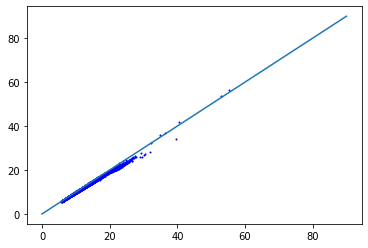

In [10]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])


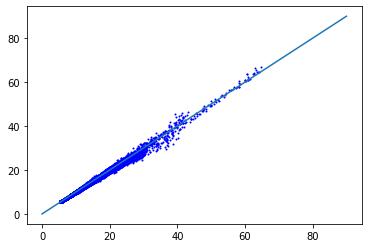

In [11]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

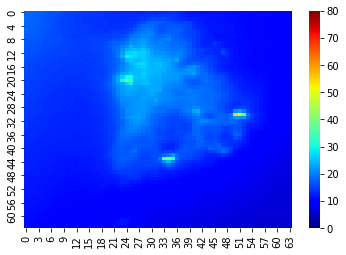

In [12]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

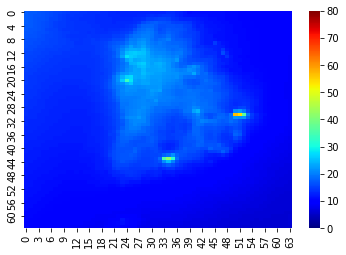

In [13]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

### 설명네트워크 구축

* 픽셀별 설명모델 구축(64*64)
* 병합해서 64*64크기의 기여도 이미지 생성
* Unet 이든 뭐든 서로게이트모델 생성

In [29]:
class Unet_explain(tf.keras.Model): 
    def __init__(self,): 
        super(Unet_explain, self).__init__()

        self.enc1_1 = CBR2d(out_channels = 128) 
        self.enc1_2 = CBR2d(out_channels=128)
            
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        self.enc2_1 = CBR2d(out_channels=256)
        self.enc2_2 = CBR2d(out_channels=256)
        
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        self.enc3_1 = CBR2d(out_channels=512)
        self.enc3_2 = CBR2d(out_channels=512)
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        
        self.enc4_1 = CBR2d(out_channels=1024)

        self.dec4_1 = CBR2d(out_channels=512)

        self.unpool3 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=2,strides=(2, 2))

        self.dec3_2 = CBR2d(out_channels=512)
        self.dec3_1 = CBR2d(out_channels=256)

        self.unpool2 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=2,strides=(2, 2))

        self.dec2_2 = CBR2d(out_channels=256)
        self.dec2_1 = CBR2d(out_channels=128)

        self.unpool1 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=2,strides=(2, 2))

        self.dec1_2 = CBR2d(out_channels=128)
        self.dec1_1 = CBR2d(out_channels=128)

        self.outlayer = tf.keras.layers.Conv2D(4,kernel_size = 1)
              
    def call(self, input): 
      
        enc1_1 = self.enc1_1(input)
        enc1_2 = self.enc1_2(enc1_1)
      
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2= self.pool2(enc2_2)
  
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3= self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        dec4_1 = self.dec4_1(enc4_1)
       
        unpool3 = self.unpool3(dec4_1)
    
        cat3 = tf.keras.layers.Concatenate(axis=3)([unpool3, enc3_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        
        unpool2 = self.unpool2(dec3_1)
        
        cat2 = tf.keras.layers.Concatenate(axis=3)([unpool2, enc2_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        
        unpool1 = self.unpool1(dec2_1)
        
        cat1 = tf.keras.layers.Concatenate(axis=3)([unpool1, enc1_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        
        x = self.outlayer(dec1_1)
        return x

In [30]:
# 데이터셋 구축
train_pred_tensor = net_1(x_train_tensor)

batch_size = 20
epoch = 200
buffer_len = len(train_pred_tensor)
n_run = np.ceil(len(train_pred_tensor)/batch_size)

train_explain_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(train_pred_tensor),))
explain_shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

net_explain = Unet_explain()


In [32]:
train_pred_tensor[:,0,0,0].numpy()

array([ 9.96812  ,  9.8044195, 10.120079 , 10.093357 , 10.052361 ,
        9.887015 ,  9.777276 , 10.1076355,  9.664455 ,  9.836151 ,
       10.004654 , 10.048511 ,  9.934327 , 10.065267 , 10.07521  ,
       10.036467 , 10.173218 , 10.170496 ,  9.980176 ,  9.960871 ,
       10.008673 ,  9.918403 ,  9.919156 , 10.021251 , 10.1988325,
        9.910936 , 10.105861 ,  9.754115 ,  9.987516 ,  9.876133 ,
        9.830105 ,  9.981879 , 10.033314 , 10.09455  , 10.183161 ,
        9.962566 ,  9.956429 ,  9.853809 ,  9.864693 ,  9.981903 ,
       10.155419 , 10.017556 ,  9.966364 , 10.015354 ,  9.740371 ,
        9.84685  , 10.18824  , 10.023451 ,  9.966821 ,  9.993275 ,
        9.873074 , 10.06753  ,  9.811411 , 10.004801 ,  9.985371 ,
        9.959787 , 10.002322 ,  9.920055 ,  9.93028  , 10.017261 ,
       10.127109 ,  9.930402 ,  9.999891 , 10.1064205,  9.949886 ,
       10.002146 , 10.002786 ,  9.838597 , 10.087294 ,  9.85163  ],
      dtype=float32)

* 픽셀별 surrogate하여 평균 shap value 추정

In [ ]:
%%time
shape_val_list = []

for x_cor in range(64):
    
        for y_cor in range(64):
                print(x_cor,", ",y_cor)

                xgb_0_0_target = train_pred_tensor[:,x_cor,y_cor,0].numpy()  # 0,0 픽셀의 예측값 70개(테스트셋 70개)
                xgb_0_0_input = x_train_tensor.numpy().reshape(70,64*64*4)


                params = {
                        # 'booster':'gbtree', # [gbtree, gblinear, dart]
                        "tree_method": "hist", 
                        'objective':'reg:squaredlogerror',
                        # 'objective':'reg:squaredlogerror',binary:logistic
                        "verbosity": 0,
                                }

                early_stop = xgb.callback.EarlyStopping(rounds=10,
                                                        data_name='val'
                                                        )

                dtrain = xgb.DMatrix(data=xgb_0_0_input, label=xgb_0_0_target)

                model = xgb.train(params,
                                dtrain,
                                evals=[(dtrain,'train'),(dtrain,'val')],
                                callbacks = [early_stop],
                                num_boost_round=100,)

                shapley_vals = xgb.Booster.predict(model,dtrain, pred_contribs=True)
                shape_val_list.append(shapley_vals)

                break
        break
# pickle.dump(shape_val_list, open('shap_val_list.p', "wb"))    

In [58]:
xgb_0_0_target = train_pred_tensor[:,33,50,0].numpy()  # 0,0 픽셀의 예측값 70개(테스트셋 70개)
xgb_0_0_input = x_train_tensor.numpy().reshape(70,64*64*4)


params = {
        # 'booster':'gbtree', # [gbtree, gblinear, dart]
        "tree_method": "hist", 
        'objective':'reg:squaredlogerror',
        # 'objective':'reg:squaredlogerror',binary:logistic
        "verbosity": 0,
                }

early_stop = xgb.callback.EarlyStopping(rounds=20,
                                        data_name='val'
                                        )

dtrain = xgb.DMatrix(data=xgb_0_0_input, label=xgb_0_0_target)

model = xgb.train(params,
                dtrain,
                evals=[(dtrain,'train'),(dtrain,'val')],
                callbacks = [early_stop],
                num_boost_round=100,)

shapley_vals = xgb.Booster.predict(model,dtrain, pred_contribs=True)
shape_val_list.append(shapley_vals)

[0]	train-rmsle:3.30544	val-rmsle:3.30544
[1]	train-rmsle:3.10079	val-rmsle:3.10079
[2]	train-rmsle:2.90019	val-rmsle:2.90019
[3]	train-rmsle:2.70449	val-rmsle:2.70449
[4]	train-rmsle:2.51479	val-rmsle:2.51479
[5]	train-rmsle:2.33247	val-rmsle:2.33247
[6]	train-rmsle:2.15918	val-rmsle:2.15918
[7]	train-rmsle:1.99672	val-rmsle:1.99672
[8]	train-rmsle:1.84678	val-rmsle:1.84678
[9]	train-rmsle:1.71061	val-rmsle:1.71061
[10]	train-rmsle:1.58872	val-rmsle:1.58872
[11]	train-rmsle:1.48083	val-rmsle:1.48083
[12]	train-rmsle:1.38597	val-rmsle:1.38597
[13]	train-rmsle:1.30275	val-rmsle:1.30275
[14]	train-rmsle:1.30275	val-rmsle:1.30275
[15]	train-rmsle:1.30275	val-rmsle:1.30275
[16]	train-rmsle:1.30275	val-rmsle:1.30275
[17]	train-rmsle:1.30275	val-rmsle:1.30275
[18]	train-rmsle:1.30275	val-rmsle:1.30275
[19]	train-rmsle:1.30275	val-rmsle:1.30275
[20]	train-rmsle:1.30275	val-rmsle:1.30275
[21]	train-rmsle:1.30275	val-rmsle:1.30275
[22]	train-rmsle:1.30275	val-rmsle:1.30275
[23]	train-rmsle:1.30

In [63]:
xgb.Booster.predict(model,dtrain, pred_contribs=False)

array([12.82818, 12.82818, 12.82818, 12.82818, 12.82818, 12.82818,
       12.82818, 12.82818, 12.82818, 12.82818, 12.82818, 12.82818,
       12.82818, 12.82818, 12.82818, 12.82818, 12.82818, 12.82818,
       12.82818, 12.82818, 12.82818, 12.82818, 12.82818, 12.82818,
       12.82818, 12.82818, 12.82818, 12.82818, 12.82818, 12.82818,
       12.82818, 12.82818, 12.82818, 12.82818, 12.82818, 12.82818,
       12.82818, 12.82818, 12.82818, 12.82818, 12.82818, 12.82818,
       12.82818, 12.82818, 12.82818, 12.82818, 12.82818, 12.82818,
       12.82818, 12.82818, 12.82818, 12.82818, 12.82818, 12.82818,
       12.82818, 12.82818, 12.82818, 12.82818, 12.82818, 12.82818,
       12.82818, 12.82818, 12.82818, 12.82818, 12.82818, 12.82818,
       12.82818, 12.82818, 12.82818, 12.82818], dtype=float32)

In [59]:
np.max(shapley_vals[:,:-1])

0.0

In [64]:
train_pred_tensor[:,33,50,0].numpy()

array([50.286068, 53.61408 , 62.697468, 56.052364, 47.116108, 38.536785,
       51.99112 , 49.304985, 34.38645 , 41.452705, 34.746468, 51.077827,
       38.763508, 40.346256, 62.027576, 56.61583 , 60.296753, 62.30584 ,
       53.35497 , 39.725487, 39.877903, 49.738075, 65.88454 , 36.972385,
       51.2608  , 40.25734 , 66.57636 , 33.227554, 41.186474, 37.22289 ,
       42.624992, 53.17685 , 36.18165 , 39.674458, 67.65406 , 58.168564,
       38.895   , 44.213924, 62.110367, 56.195988, 66.86336 , 41.750694,
       57.242146, 52.449314, 38.411316, 46.906944, 50.427856, 63.702393,
       44.130898, 66.938446, 65.05486 , 63.926414, 38.60387 , 59.961082,
       40.639915, 54.93857 , 36.92702 , 56.934906, 46.298225, 53.766117,
       35.567482, 66.52906 , 34.979553, 38.407047, 46.658443, 54.22761 ,
       56.581398, 60.62194 , 63.040615, 59.648335], dtype=float32)

In [49]:
for i in range(64):
    for j in range(64):
        print(i,",",j,"_",np.max(train_pred_tensor[:,i,j,0].numpy()))
        

0 , 0 _ 10.1988325
0 , 1 _ 10.075624
0 , 2 _ 9.924636
0 , 3 _ 9.8081
0 , 4 _ 9.622349
0 , 5 _ 9.469179
0 , 6 _ 9.31041
0 , 7 _ 9.209201
0 , 8 _ 9.109581
0 , 9 _ 9.01792
0 , 10 _ 8.92952
0 , 11 _ 8.768986
0 , 12 _ 8.7813835
0 , 13 _ 8.659558
0 , 14 _ 8.580148
0 , 15 _ 8.4162245
0 , 16 _ 8.374018
0 , 17 _ 8.361256
0 , 18 _ 8.424112
0 , 19 _ 8.786982
0 , 20 _ 9.641549
0 , 21 _ 9.963552
0 , 22 _ 10.17371
0 , 23 _ 10.105592
0 , 24 _ 9.709979
0 , 25 _ 9.443743
0 , 26 _ 8.978386
0 , 27 _ 8.253461
0 , 28 _ 7.693359
0 , 29 _ 7.5133376
0 , 30 _ 7.4048166
0 , 31 _ 7.351443
0 , 32 _ 7.4290895
0 , 33 _ 7.3453984
0 , 34 _ 7.3108134
0 , 35 _ 7.2371426
0 , 36 _ 7.3076754
0 , 37 _ 7.214679
0 , 38 _ 7.099861
0 , 39 _ 6.974408
0 , 40 _ 6.921632
0 , 41 _ 6.841806
0 , 42 _ 6.80192
0 , 43 _ 6.627329
0 , 44 _ 6.6216063
0 , 45 _ 6.548621
0 , 46 _ 6.4729805
0 , 47 _ 6.415549
0 , 48 _ 6.286947
0 , 49 _ 6.2222466
0 , 50 _ 6.1312647
0 , 51 _ 6.0635653
0 , 52 _ 6.075072
0 , 53 _ 5.95386
0 , 54 _ 5.906861
0 , 55 _ 

In [ ]:
pickle.dump(shape_val_list, open('shap_val_list.p', "wb"))    

* shap 밸류로 플롯 그리기

In [6]:
# pickle.dump(shape_val_list, open('shap_val_list.p', "wb"))     
shape_val_list = pickle.load(open('shap_val_list.p', "rb"))  
mean_shap_bypixel = np.mean(shape_val_list,axis=0)
explanNet_train_target = mean_shap_bypixel[:,:-1].reshape([70,64,64,4])

In [15]:
for i in range(4000):
    print(np.max(shape_val_list[i][:,:-1]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
# 전체 시나리오 트레인 테슽별 인풋, target 비교

import matplotlib

colors = ["#F80206", "#F53639", "#F77576", "#F6A1A3","#000000","#B7AEF8","#897AF6","#5843F9","#2003F9"]
colors.reverse()
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("name", colors)
norm = plt.Normalize(-0.0000008, 0.0000008)

for i in range(len(y_train)):
    print(i)
    fig = plt.figure(figsize = (40,100))
    
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx')
    sns.heatmap(x_train[i,:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=15, ) # vmin=-2, vmax=2

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx_contribution')
    sns.heatmap(explanNet_train_target[i,:,:,0][::-1], cmap = cmap,ax = ax1_2,norm=norm)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2')
    sns.heatmap(x_train[i,:,:,1][::-1], cmap = 'jet',ax = ax2_1,vmin=0, vmax=8) # vmin=-2, vmax=2

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2_contribution')
    sns.heatmap(explanNet_train_target[i,:,:,1][::-1], cmap = cmap,ax = ax2_2,norm=norm)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs')
    sns.heatmap(x_train[i,:,:,2][::-1], cmap = 'jet',ax = ax3_1,vmin=0, vmax=11) # vmin=-2, vmax=2

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs_contribution')
    sns.heatmap(explanNet_train_target[i,:,:,2][::-1], cmap = cmap,ax = ax3_2,norm=norm)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3')
    sns.heatmap(x_train[i,:,:,3][::-1], cmap = 'jet',ax = ax4_1,vmin=0, vmax=4) # vmin=-2, vmax=2

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3_contribution')
    sns.heatmap(explanNet_train_target[i,:,:,3][::-1], cmap = cmap,ax = ax4_2,norm=norm)
    

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('PredValue')
    sns.heatmap(train_pred_tensor.numpy()[i,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('TrueValue')
    sns.heatmap(y_train_resize_tensor.numpy()[i,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)



    # train_pred_tensor.numpy()[i,:,:,0][::-1]
    plt.savefig(os.path.join(path,"plots","shap_ensemble_contribution",f"shap_mean_contribution_{i}.png"))
    plt.close()
print('clear')

* explainNetwork 학습시키기